# Experiments with inspection jobs

Let's start with using Ceph adapter:

In [1]:
from thoth.storages import InspectionResultsStore

inspection_store = InspectionResultsStore()
inspection_store.connect()

In [2]:
help(inspection_store)

Help on InspectionResultsStore in module thoth.storages.inspections object:

class InspectionResultsStore(thoth.storages.result_base.ResultStorageBase)
 |  Adapter for persisting Amun inspection results.
 |  
 |  Method resolution order:
 |      InspectionResultsStore
 |      thoth.storages.result_base.ResultStorageBase
 |      thoth.storages.base.StorageBase
 |      builtins.object
 |  
 |  Class methods defined here:
 |  
 |  get_document_id(document:dict) -> str from abc.ABCMeta
 |      Get id under which the given document will be stored.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  RESULT_TYPE = 'inspection'
 |  
 |  SCHEMA = None
 |  
 |  __abstractmethods__ = frozenset()
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from thoth.storages.result_base.ResultStorageBase:
 |  
 |  __init__(self, deployment_name=None, *, host:str=None, key_id:s

In [3]:
doc_id, doc = next(inspection_store.iterate_results())  # sample

## Setup

In [4]:
import itertools

In [5]:
from matplotlib.colors import to_hex

from plotnine import *
from plotnine import options

import cufflinks as cf

from plotly import tools
from plotly import graph_objs as go
from plotly import figure_factory as ff 
from plotly.offline import iplot, init_notebook_mode

import seaborn as sns

In [6]:
cf.go_offline()  # offline cufflinks mode
cf.set_config_file(theme='pearl')

init_notebook_mode(connected=True)

In [7]:
import numpy as np
import pandas as pd

from pandas.io.json import json_normalize

In [8]:
from ipywidgets import interactive, interact, widgets 
from ipywidgets import Text, Textarea
from ipywidgets import HBox, VBox

In [9]:
from typing import Any, List

In [10]:
from IPython.core.display import display, HTML, Javascript

In [11]:
### normalization

def normalize(series: pd.Series, kind = 'minmax', **kwargs) -> pd.Series:
    """Normalize given series."""
    min_ = series.min()
    
    if kind == 'minmax':
        result = (series - min_) / (series.max() - min_)
    else:
        pass  # TODO: other kinds of normalization
        
    return result

def standardize(series: pd.Series, **kwargs) -> pd.Series:
    """Standardize given series."""
    
    return (series - series.mean()) / series.std()

def normalize_df(df: pd.DataFrame, cols: list, groups = [], **kwargs) -> pd.DataFrame:
    """Normalize columns of given DataFrame.
    
    :returns: DataFrame normlized at given columns
    """
    df_cpy = df.copy()
    
    if groups:
        df_cpy[cols] = df_cpy.groupby(groups)[cols].apply(normalize, **kwargs)
        
    else:
        df_cpy[cols] = df_cpy[cols].apply(normalize)
    
    return df_cpy

def standardize_df(df: pd.DataFrame, cols: list, groups = [], **kwargs) -> pd.DataFrame:
    """Standardize columns of given DataFrame.
    
    :returns: DataFrame standardized at given columns
    """
    df_cpy = df.copy()
    
    if groups:
        df_cpy[cols] = df_cpy.groupby(groups)[cols].apply(standardize, **kwargs)
        
    else:
        df_cpy[cols] = df_cpy[cols].apply(standardize)
    
    return df_cpy

In [52]:
from dataclasses import *

# Job log

_DTYPE = bool
_ATYPE = {'not_impl', 'try_call'}
_INTS = {'ncpus'}
_STRS = {'nbits'}

def _typeof(key: str):
    """Get `hwinfo` attribute type by key."""
    _type = _DTYPE
    
    if key in _INTS:
        _type = int
    elif key in _STRS:
        _type = str
    elif key in _ATYPE:
        _type = Any
    
    return _type
        

# create hwinfo dataclass using factory
def _make_hwinfo(doc: dict) -> "HWInfo":
    """Factory function generating HWInfo dataclass."""
    cls = make_dataclass(
        'HWInfo', [
            (k, _typeof(k)) for k, v in doc['job_log']['hwinfo']['cpu'].items()
        ]
    )
    cls.__flag_proto__ = False
    
    return cls

# create hwinfo proto
@dataclass
class HWInfo:

    __flag_proto__ = True

@dataclass
class InspectionJobLog:
    exit_code: int
    hwinfo: HWInfo
    script_sha256: str
    stderr: str
    stdout: str
        
    def __post_init__(self):
        if not isinstance(self.hwinfo, HWInfo):
            self.hwinfo = HWInfo(**self.hwinfo['cpu'])
            
# Specification

import hashlib

@dataclass
class RequestsHardware:
    cpu_family: int
    cpu_model: int
    physical_cpus: int
    processor: str

@dataclass
class Requests:
    cpu: str
    hardware: RequestsHardware
    memory: str
        
    def __post_init__(self):
        if not isinstance(self.hardware, RequestsHardware):
            self.hardware = RequestsHardware(**self.hardware)
            
@dataclass
class Package:
    name: str
    index: str
    version: str
        
    hashes: List[str] = field(default_factory=list)
            
@dataclass
class Requirements:
    packages: List[Package]
    requires: dict
    source: dict
        
    dev_packages: List[Package] = field(default_factory=list)
        
    def __post_init__(self):
        if not isinstance(self.packages, list) \
        or not all(isinstance(p, Package) for p in self.packages):
            self.packages = [
                Package(**dict(name=p, **v)) for p, v in self.packages.items()
            ]
            
        if not isinstance(self.dev_packages, list) \
        or not all(isinstance(p, Package) for p in self.dev_packages):
            self.dev_packages = [
                Package(**dict(name=p, **v)) for p, v in self.dev_packages.items()
            ]
    
            
@dataclass
class RequirementsLocked:
    _meta: dict
    default: List[Package]
    develop: List[Package]
        
    def __post_init__(self):
        if not isinstance(self.default, list) \
        or not all(isinstance(p, Package) for p in self.default):
            self.default = [
                Package(**dict(name=p, **v)) for p, v in self.default.items()
            ]
            
        if not isinstance(self.develop, list) \
        or not all(isinstance(p, Package) for p in self.develop):
            self.develop = [
                Package(**dict(name=p, **v)) for p, v in self.develop.items()
            ]
        
@dataclass
class Python:
    
    requirements: Requirements
    requirements_locked: RequirementsLocked
        
    stack_digest: str = None
    requirements_digest: str = None
        
    def __post_init__(self):
        if not isinstance(self.requirements, Requirements):
            try:
                self.requirements['dev_packages'] = self.requirements.pop('dev-packages')
            except KeyError:
                pass
            self.requirements = Requirements(**self.requirements)
            
        if not isinstance(self.requirements_locked, RequirementsLocked):
            self.requirements_locked = RequirementsLocked(**self.requirements_locked)
            
        packages = [' '.join(astuple(p)[:3]) for p in self.requirements_locked.default]
        package_names = [p.name for p in self.requirements_locked.default]
        
        self.requirements_digest = hashlib.sha256(
            ' '.join(package_names).encode()).hexdigest()
        
        self.stack_digest = hashlib.sha256(' '.join(packages).encode()).hexdigest()
        
            
@dataclass
class InspectionSpecification:
    base: str
    build: Requests
    files: List[str]
    packages: List[str]
    python: Python
    run: dict
    script: List['str']
    

    def __post_init__(self):
        if not isinstance(self.build, Requests):
            self.build = Requests(**self.build['requests'])
            
        if not isinstance(self.run, Requests):
            self.run = Requests(**self.run['requests'])
        
        if not isinstance(self.python, Python):
            self.python = Python(**self.python)
           
# Status

@dataclass
class Status:
    container: str
    exit_code: int
    finished_at: str
    reason: str
    started_at: str
    state: str

@dataclass
class InspectionStatus:
    build: Status
    job: Status
        
    def __post_init__(self):
        if not isinstance(self.build, Status):
            self.build = Status(**self.build)
            
        if not isinstance(self.job, Status):
            self.job = Status(**self.job)
            
            
# Inspection Result

import copy
import warnings

@dataclass(init=False, frozen=True)
class InspectionResult:
        
    build_log: str
    inspection_id: str
    job_log: InspectionJobLog
    specification: InspectionSpecification
    status: InspectionStatus

    def __init__(
        self,
        build_log: str,
        inspection_id: str,
        job_log: dict,
        specification: dict,
        status: dict):
        """Parse the JSON data passed from Ceph object storage and initialize dataclass.
        
        This class definition assumes that it is initialized with dictionary
        returned by InspectionResultsStore.
        """
        
        object.__setattr__(self, 'build_log', build_log)
        object.__setattr__(self, 'inspection_id', inspection_id)
        object.__setattr__(self, 'job_log', InspectionJobLog(**job_log))
        object.__setattr__(self, 'specification', InspectionSpecification(**specification))
        object.__setattr__(self, 'status', InspectionStatus(**status))
        
        InspectionResult.__repr_full__ = InspectionResult.__repr__
        
        def __repr__override(self):
            
            attr_dict = asdict(self)
            attr_dict['build_log'] = '<hidden>'
            
            return f"{self.__class__.__name__}({repr(attr_dict)})"
        
        InspectionResult.__repr__ = __repr__override
        
        # warn about suppressed output for `build_log` attribute
        self._warn_once() 
        
    @staticmethod
    def _warn_once():
        """Warn about suppressed output for `build_log` attribute."""
        warnings.warn("The `build_log` attribute content is hidden by default."
                      "If you want to display it, use `__repr_full__` method instead.")
        
InspectionResult._warn_once = lambda s: None

---

In [12]:
doc['job_log'].keys()

dict_keys(['exit_code', 'hwinfo', 'script_sha256', 'stderr', 'stdout'])

---

In [53]:
# Create DataFrame according to the InspectionResult schema

HWInfo = None

inspection_results = []

for document_id, document in inspection_store.iterate_results():
    
    if HWInfo is None:
        HWInfo = _make_hwinfo(document)  # HWInfo factory
        
    # pop build logs to save some memory (not necessary for now)
    document['build_log'] = None
    inspection_results.append(InspectionResult(**document))

In [54]:
f"Number of documents: {len(inspection_results)}"

'Number of documents: 797'

---

---

## Analysis setup

In [55]:
df = json_normalize([asdict(r) for r in inspection_results], sep = "__")  # each row resembles InspectionResult

In [56]:
df.head(3)

build_log             inspection_id  job_log__exit_code  \
0      None  inspect-002c9fbb7513b20b                   0   
1      None  inspect-003e9fc7135f503f                   0   
2      None  inspect-0044bd85b0d234cb                   0   

   job_log__hwinfo__has_3dnow  job_log__hwinfo__has_3dnowext  \
0                       False                          False   
1                       False                          False   
2                       False                          False   

  job_log__hwinfo__has_Altivec job_log__hwinfo__has_f00f_bug  \
0                         None                          None   
1                         None                          None   
2                         None                          None   

  job_log__hwinfo__has_fdiv_bug  job_log__hwinfo__has_mmx  \
0                          None                      True   
1                          None                      True   
2                          None                      True   

   job_log__hwinfo__has_sse         ...          status__build__finished_at  \
0                      True         ...                2019-01-22T11:22:36Z   
1                      True         ...                2019-01-22T11:26:12Z   
2                      True         ...                2019-01-22T11:29:28Z   

   status__build__reason  status__build__started_at  status__build__state  \
0              Completed       2019-01-22T11:20:50Z            terminated   
1              Completed       2019-01-22T11:24:16Z            terminated   
2              Completed       2019-01-22T11:27:38Z            terminated   

                              status__job__container  status__job__exit_code  \
0  3cc5360208e33f37c7e3d8676cf4d907ebfdb5d10f72ca...                       0   
1  1296b9a19d82867512ea7bc4a30ba22a9ed01887948249...                       0   
2  738556b135f8d33fa8a58eed19ba79636413bd0e0ed7ff...                       0   

   status__job__finished_at status__job__reason  status__job__started_at  \
0      2019-01-22T11:24:07Z           Completed     2019-01-22T11:23:56Z   
1      2019-01-22T11:27:29Z           Completed     2019-01-22T11:27:19Z   
2      2019-01-22T11:30:52Z           Completed     2019-01-22T11:30:44Z   

   status__job__state  
0          terminated  
1          terminated  
2          terminated  

[3 rows x 114 columns]

In [57]:
import string

unique_stacks = df.filter(like='specification').drop_duplicates(subset='specification__python__requirements_digest')
unique_stacks['stack'] = list(string.ascii_uppercase[:len(unique_stacks)])
unique_stacks

specification__base specification__build__cpu  \
0             fedora:29                      500m   
171           fedora:29                      500m   

     specification__build__hardware__cpu_family  \
0                                             6   
171                                           6   

     specification__build__hardware__cpu_model  \
0                                           94   
171                                         94   

     specification__build__hardware__physical_cpus  \
0                                               32   
171                                             32   

    specification__build__hardware__processor specification__build__memory  \
0        Intel Core Processor (Skylake, IBRS)                          1Gi   
171      Intel Core Processor (Skylake, IBRS)                          1Gi   

    specification__files    specification__packages  \
0                   None  [pipenv, which, python36]   
171                 None  [pipenv, which, python36]   

    specification__python__requirements__dev_packages  ...   \
0                                                  []  ...    
171                                                []  ...    

    specification__python__requirements_locked__develop  \
0                                                   []    
171                                                 []    

                   specification__python__stack_digest  \
0    edbd2fd6350b3861afef5b907cd964b50922c0227f3ec0...   
171  a8a14df7391a84d4ed1398b1f870eef225033baa2e1fcf...   

    specification__run__cpu specification__run__hardware__cpu_family  \
0                      500m                                        6   
171                    500m                                        6   

    specification__run__hardware__cpu_model  \
0                                        94   
171                                      94   

     specification__run__hardware__physical_cpus  \
0                                             32   
171                                           32   

    specification__run__hardware__processor specification__run__memory  \
0      Intel Core Processor (Skylake, IBRS)                        8Gi   
171    Intel Core Processor (Skylake, IBRS)                        8Gi   

                                 specification__script stack  
0    https://raw.githubusercontent.com/thoth-statio...     A  
171  https://raw.githubusercontent.com/thoth-statio...     B  

[2 rows x 29 columns]

> {{len(unique_stacks)}} unique stack specifications

In [58]:
# remap digests for future usage
package_names = [
    [p.get('name') for p in spec]
    for idx, spec in enumerate(unique_stacks['specification__python__requirements__packages'])
]

unique_package_names = set(itertools.chain(*package_names))
print(f"Package names: {unique_package_names}")

Package names: {'absl-py', 'termcolor', 'markdown', 'tensorboard', 'tensorflow', 'bleach', 'astor', 'setuptools', 'wheel', 'olefile', 'webencodings', 'werkzeug', 'gast', 'six', 'pillow', 'html5lib'}


In [59]:
{
    unique_stacks['stack'].iloc[idx]: set(pn).symmetric_difference(unique_package_names)
    for idx, pn in enumerate(package_names)
}

{'A': set(), 'B': {'absl-py', 'bleach'}}

In [60]:
df = df.merge(unique_stacks.filter(['specification__python__requirements_digest',
                                    'stack']))

---

# Univariate

## Status

### Setup

In [61]:
df.head()

build_log             inspection_id  job_log__exit_code  \
0      None  inspect-002c9fbb7513b20b                   0   
1      None  inspect-003e9fc7135f503f                   0   
2      None  inspect-0044bd85b0d234cb                   0   
3      None  inspect-005576c22b9ee846                   0   
4      None  inspect-005674620e23c058                   0   

   job_log__hwinfo__has_3dnow  job_log__hwinfo__has_3dnowext  \
0                       False                          False   
1                       False                          False   
2                       False                          False   
3                       False                          False   
4                       False                          False   

  job_log__hwinfo__has_Altivec job_log__hwinfo__has_f00f_bug  \
0                         None                          None   
1                         None                          None   
2                         None                          None   
3                         None                          None   
4                         None                          None   

  job_log__hwinfo__has_fdiv_bug  job_log__hwinfo__has_mmx  \
0                          None                      True   
1                          None                      True   
2                          None                      True   
3                          None                      True   
4                          None                      True   

   job_log__hwinfo__has_sse  ...    status__build__reason  \
0                      True  ...                Completed   
1                      True  ...                Completed   
2                      True  ...                Completed   
3                      True  ...                Completed   
4                      True  ...                Completed   

   status__build__started_at  status__build__state  \
0       2019-01-22T11:20:50Z            terminated   
1       2019-01-22T11:24:16Z            terminated   
2       2019-01-22T11:27:38Z            terminated   
3       2019-01-22T11:30:59Z            terminated   
4       2019-01-22T11:34:19Z            terminated   

                              status__job__container  status__job__exit_code  \
0  3cc5360208e33f37c7e3d8676cf4d907ebfdb5d10f72ca...                       0   
1  1296b9a19d82867512ea7bc4a30ba22a9ed01887948249...                       0   
2  738556b135f8d33fa8a58eed19ba79636413bd0e0ed7ff...                       0   
3  d31a028882b9ef570e19e1998f00fb4199e47d7fb08eb2...                       0   
4  58e7beec785ea744ccd34cebf84e946b4fb11cda565460...                       0   

   status__job__finished_at  status__job__reason status__job__started_at  \
0      2019-01-22T11:24:07Z            Completed    2019-01-22T11:23:56Z   
1      2019-01-22T11:27:29Z            Completed    2019-01-22T11:27:19Z   
2      2019-01-22T11:30:52Z            Completed    2019-01-22T11:30:44Z   
3      2019-01-22T11:34:10Z            Completed    2019-01-22T11:33:58Z   
4      2019-01-22T11:37:30Z            Completed    2019-01-22T11:37:19Z   

   status__job__state  stack  
0          terminated      A  
1          terminated      A  
2          terminated      A  
3          terminated      A  
4          terminated      A  

[5 rows x 115 columns]

In [62]:
df_status = df.filter(regex='status') \
    .dropna(how='all') \
    .join(df[['inspection_id', 'specification__python__stack_digest', 'stack']]) \
    .rename(columns={'specification__python__stack_digest': 'stack_digest'})

df_status.columns = df_status.columns.str.replace('status__', '')

In [63]:
df_status = df_status \
    .filter(regex='(stack.*)|(build__.*)|(.*id)') \
    .assign(kind='build') \
    .rename(columns=lambda s: s.replace('build__', '')) \
    .append(
        df_status.filter(regex='(stack.*)|(job__.*)') \
            .assign(kind='job') \
            .rename(columns=lambda s: s.replace('job__', ''))
    )

In [64]:
df_status.started_at = df_status.started_at.apply(pd.to_datetime)
df_status.finished_at = df_status.finished_at.apply(pd.to_datetime)

df_status['duration'] = pd.to_timedelta(df_status.finished_at - df_status.started_at).dt.total_seconds()

df_status = df_status.reindex(sorted(df_status.columns), axis = 1)

In [65]:
df_status.head()

container  duration  exit_code  \
0  9fa97a7b736bdf5b10070c372bfa320d876591347d7442...     106.0          0   
1  3d07b4fa447c8c68a74c9c99cb56303ae888d833ce2704...     116.0          0   
2  d121a0a33882f755d0bdcb0e54f75f22a948735033f6d6...     110.0          0   
3  20bae400be430327df1cab34b1035763fa62014ec9db07...     117.0          0   
4  4a04447d3d11e638ef9ff9a3af31be335024df04745218...     114.0          0   

          finished_at             inspection_id   kind     reason stack  \
0 2019-01-22 11:22:36  inspect-002c9fbb7513b20b  build  Completed     A   
1 2019-01-22 11:26:12  inspect-003e9fc7135f503f  build  Completed     A   
2 2019-01-22 11:29:28  inspect-0044bd85b0d234cb  build  Completed     A   
3 2019-01-22 11:32:56  inspect-005576c22b9ee846  build  Completed     A   
4 2019-01-22 11:36:13  inspect-005674620e23c058  build  Completed     A   

                                        stack_digest          started_at  \
0  edbd2fd6350b3861afef5b907cd964b50922c0227f3ec0... 2019-01-22 11:20:50   
1  9d4f58ce217d9633738e7df2bc492d9ba9677e5100a849... 2019-01-22 11:24:16   
2  451222005d0616d78cd9cfe9e10e133f6e000cca939880... 2019-01-22 11:27:38   
3  0a69c2e27b4765cbbc6552668aef1a3950153d8decdaa9... 2019-01-22 11:30:59   
4  4a50c124b7132c3501da39149add10d06fe4aa1b6318fa... 2019-01-22 11:34:19   

        state  
0  terminated  
1  terminated  
2  terminated  
3  terminated  
4  terminated

### Visualization

In [66]:
options.figure_size = (11, 7)

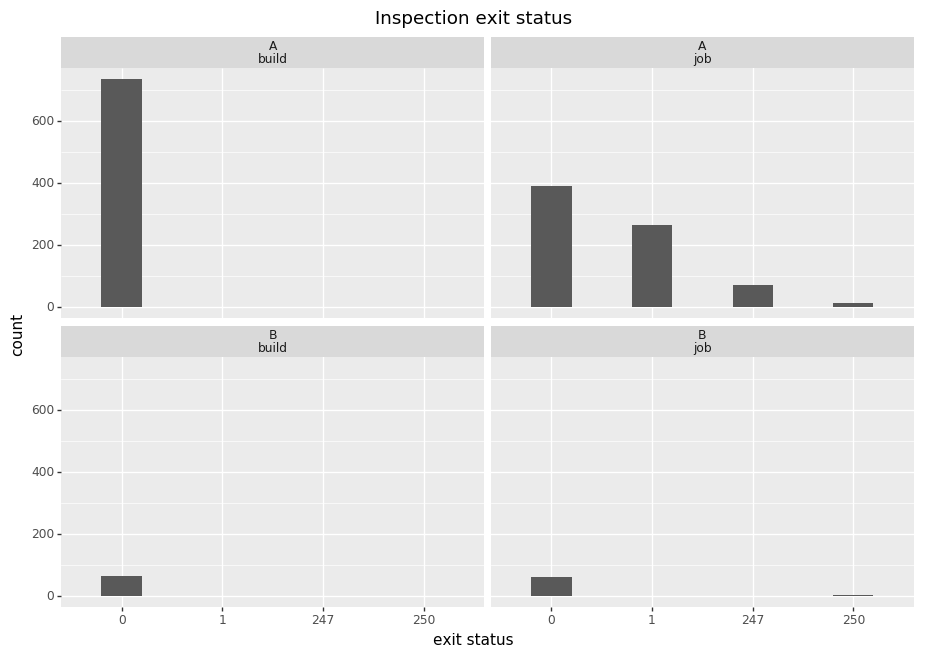

<ggplot: (-9223363245583771911)>

In [67]:
(ggplot(data = df_status, mapping = aes(x = 'factor(exit_code)')) +
     geom_bar(
         width = 0.4, position = position_dodge(width = 0.5)) +
     facet_wrap('~ stack + kind', ncol = 2) +
     xlab("exit status") +
     labs(title = "Inspection exit status")
)

> Observation: Stack group A does exhibit more errors

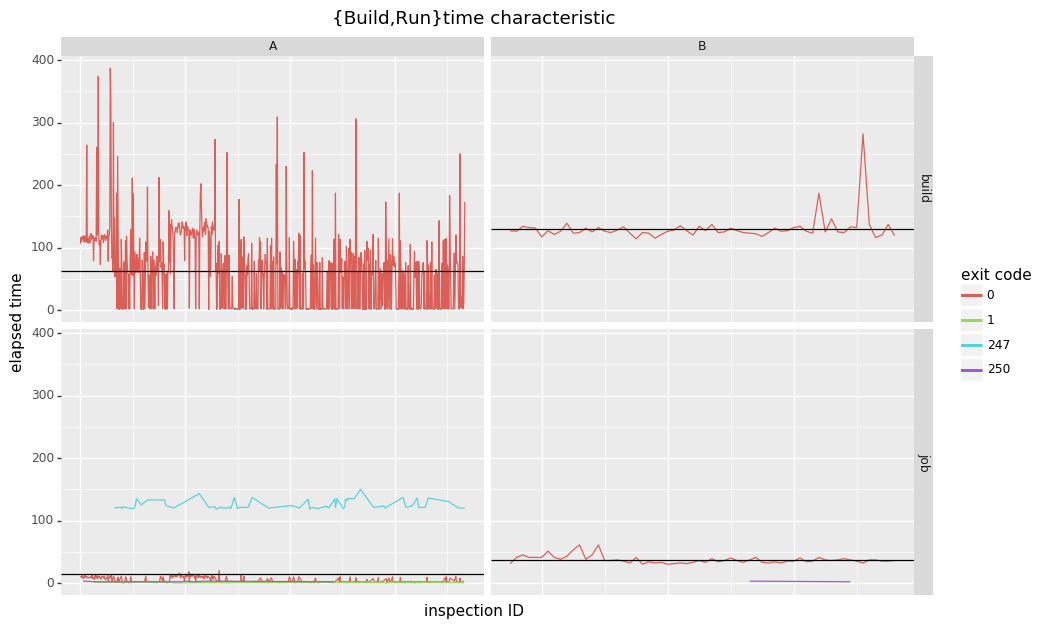

<ggplot: (-9223363245589417321)>

In [68]:
df_aux = pd.DataFrame({
    'kind': ['build', 'build', 'job', 'job'],
    'stack': ['A', 'B', 'A', 'B'],
    'mean': df_status.groupby(['kind', 'stack']).mean().duration.values
})

(ggplot(df_status, aes(x = df_status.index)) +
     geom_line(aes(y = 'duration', color = 'factor(exit_code)')) +
     geom_hline(df_aux, aes(yintercept = 'mean')) +
     facet_grid(' kind ~ stack', scales = 'free_x') +
     xlab("inspection ID") +
     ylab("elapsed time") +
     labs(title = "{Build,Run}time characteristic", color = "exit code") +
     theme(
         axis_text_x = element_blank(),
         axis_ticks_major_x = element_blank()
     )
)

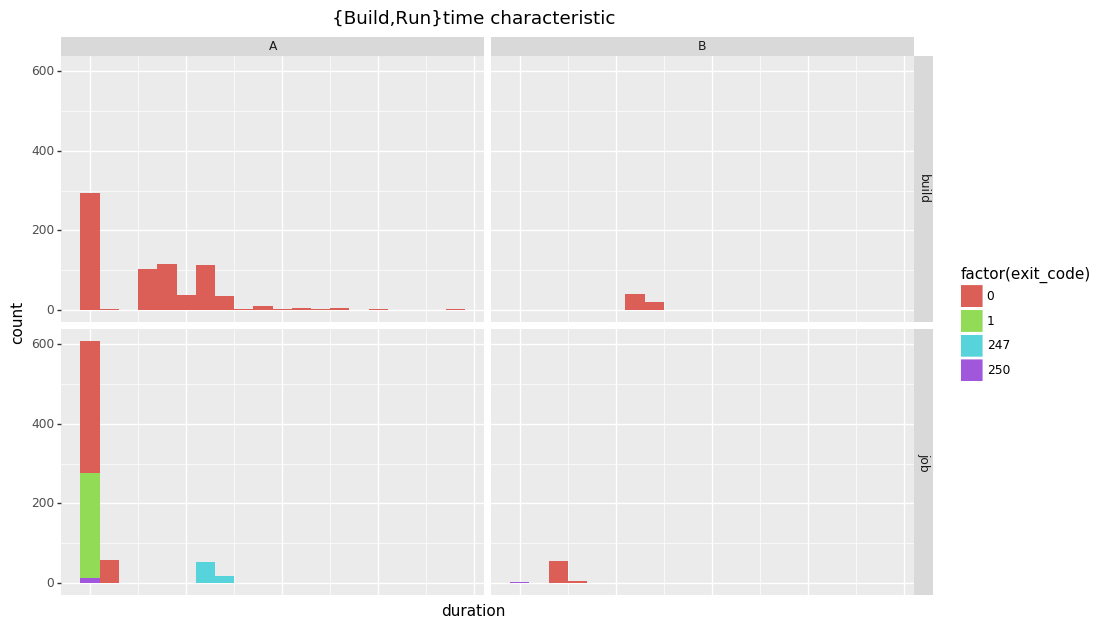

<ggplot: (-9223363245584031982)>

In [69]:
(ggplot(df_status) +
     geom_histogram(aes(x = 'duration', fill = 'factor(exit_code)'), binwidth=20) +
     facet_grid(' kind ~ stack') +
     labs(title = "{Build,Run}time characteristic", color = "exit code") +
     theme(
         axis_text_x = element_blank(),
         axis_ticks_major_x = element_blank()
     )
)

> Observation: Stack group B takes longer to build and run 

## Performance

### Setup

In [70]:
df_perf = df.filter(regex='stdout__(256|512|1024)(.*)') \
    .dropna(how='any') \
    .join(df[['inspection_id', 'specification__python__stack_digest', 'stack']]) \
    .rename(columns={'specification__python__stack_digest': 'stack_digest'})

df_perf.columns = df_perf.columns.str.replace('job_log__stdout__', '')

In [71]:
# melt
df_perf = df_perf.melt(id_vars=['inspection_id', 'stack_digest', 'stack'])
df_perf[['mat_size', 'metrics']] = pd.DataFrame(df_perf.variable.str.split('__').tolist())

# drop the melting variable
df_perf.drop('variable', axis=1, inplace=True)

# fix mat_size dtype
df_perf.mat_size = df_perf.mat_size.astype(np.int16)

# reshape
df_perf = df_perf \
    .pivot_table(index=['inspection_id', 'mat_size', 'stack', 'stack_digest'], columns='metrics', values='value') \
    .sort_values(['inspection_id', 'mat_size']) \
    .reset_index()

 # performance as reverse of elapsed time
df_perf['performance'] = 1 / df_perf.elapsed_ms

# # relabel for clarity
df_perf = df_perf.reindex(sorted(df_perf.columns), axis = 1)

In [72]:
df_perf.head()

metrics  elapsed_ms             inspection_id  mat_size  performance  \
0          0.292063  inspect-002c9fbb7513b20b       256     3.423922   
1          1.544952  inspect-002c9fbb7513b20b       512     0.647269   
2        401.081562  inspect-002c9fbb7513b20b      1024     0.002493   
3          0.444651  inspect-003e9fc7135f503f       256     2.248957   
4        105.239391  inspect-003e9fc7135f503f       512     0.009502   

metrics        rate stack                                       stack_digest  
0        114.663355     A  edbd2fd6350b3861afef5b907cd964b50922c0227f3ec0...  
1        173.580308     A  edbd2fd6350b3861afef5b907cd964b50922c0227f3ec0...  
2          5.351617     A  edbd2fd6350b3861afef5b907cd964b50922c0227f3ec0...  
3         75.315073     A  9d4f58ce217d9633738e7df2bc492d9ba9677e5100a849...  
4          2.548222     A  9d4f58ce217d9633738e7df2bc492d9ba9677e5100a849...

### Visualization

#### Raw

In [73]:
options.figure_size = (13, 7)

In [74]:
(ggplot(df_perf, aes(x = df_perf.index)) +
     # performance as reverse of elapsed time
     geom_line(aes(y = 'performance')) +
     facet_wrap('~ mat_size + stack', scales='free_x', ncol = 2) +
     xlab("inspection job") +
     ylab("performance") +
     labs(title = "Performance measure [raw]") +
     theme(
         axis_text_x = element_blank(),
         axis_ticks_major_x = element_blank()
     )
)

<ggplot: (8791262813125)>

In [75]:
for stack in df_perf['stack'].unique():
    
    df_perf.query(f"stack == '{stack}'")[['inspection_id', 'mat_size', 'elapsed_ms']] \
        .sort_values(by='inspection_id') \
        .pivot(index='inspection_id', columns='mat_size', values='elapsed_ms') \
        .iplot(kind='scatter', fill=True, subplots=True, shape=(1, 3), title = f"Stack {stack}",
               layout_update=dict(
                   xaxis=dict(
                       showticklabels=False
                   )
               ))


#### Build log view

In [76]:
# widgets

search_widget = widgets.Text(
    placeholder='Inspection ID:',
    description="Filter"
)

dropdown_widget = widgets.Dropdown(
    description="Inspection ID:",
    options=df_perf.inspection_id.unique()
)

search_button = widgets.Button(
    description="Search"
)

out = widgets.Output()

def _update_search(opt):
    dropdown_widget.options = df[df.inspection_id.str.contains(opt['new'])] \
        .inspection_id \
        .unique()
    
def _capture_inspection(*args, **kwargs):
    result = InspectionResult(**inspection_store.retrieve_document(dropdown_widget.value))
    
    out.clear_output()
    with out:
        display(df.query("inspection_id == @dropdown_widget.value"))
        display(HTML('<hr>'))
        print(result.build_log)
    

search_widget.observe(_update_search, names='value')
search_button.on_click(_capture_inspection)

# boxes

search_hbox = HBox([search_widget, dropdown_widget, search_button])

In [77]:
display(HTML("<center><h3>Inspection log search</center><br>"))
display(VBox([search_hbox, out]))

### Normalized

In [78]:
df_norm = normalize_df(df_perf, cols = ['performance'], groups = ['mat_size'])

for stack in df_norm['stack'].unique():
    
    df_norm.query(f"stack == '{stack}'")[['mat_size', 'performance']] \
        .pivot(columns='mat_size', values='performance') \
        .iplot(kind='box', subplots=True, shape=(1, 3), title = f"Stack {stack}", shared_yaxis=True)


In [79]:
df_norm = df_norm \
    .pivot(index='inspection_id', columns='mat_size', values='performance') \
    .reset_index(drop=True)

df_norm.columns = df_norm.columns.astype(str).str.replace(r"(\d+)", r"dim_\1")

fig = df_norm.iplot(
    kind='scatter',
    hoverinfo='text',
    subplots=True,
    shape=(3, 1),
    shared_xaxes=True,
    fill=True,
    title="Performance comparison w.r.t matrix size",
    xTitle="Inspection ID",
    layout_update=dict(
        height=1080,
        width=960,
        xaxis=dict(
             spikedash='solid',
             spikemode='across+marker',
             spikethickness=2
        )
    ),
    asFigure=True
)

text = df_norm.apply(lambda s: "<br>".join(map(str, s)), axis=1)

for p in fig.data:
    p.text = text

iplot(fig)

In [80]:
df_norm.iplot(
    kind='hist',
    subplots=True,
    title="Performance distribution"
)

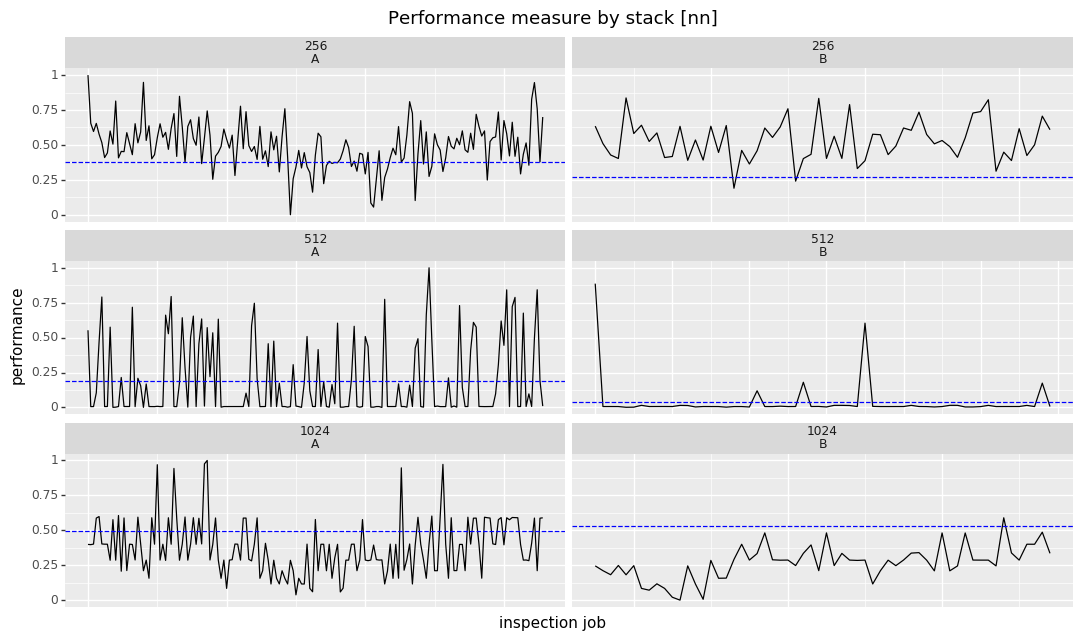

<ggplot: (8791051343715)>

In [81]:
df_norm = normalize_df(df_perf, cols = ['performance'], groups = ['mat_size'])

df_aux = pd.DataFrame({
    'stack': ['A', 'B', 'A', 'B', 'A', 'B'],
    'mat_size': [1024, 1024, 512, 512, 256, 256],
    'mean': df_norm.groupby(['mat_size', 'stack']).mean().performance.values
})

(ggplot(df_norm, aes(x = df_norm.index)) +
     geom_line(aes(y = 'performance')) +
     geom_hline(df_aux, aes(yintercept = 'mean'), color = 'blue', linetype='dashed') +
     facet_wrap('~ mat_size + stack', ncol = 2, scales='free_x') +
     xlab("inspection job") +
     ylab("performance") +
     labs(title = "Performance measure by stack [nn]") +
     theme(
         axis_text_x = element_blank(),
         axis_ticks_major_x = element_blank()
     )
)

### Performance rate

In [82]:
options.figure_size = (13, 7)

In [83]:
df_norm = normalize_df(df_perf, cols = ['performance', 'rate'], groups = ['mat_size'])

(ggplot(df_norm, aes(x = df_norm.index)) +
     geom_line(aes(y = 'performance'), color = 'red') +
     geom_line(aes(y = 'rate'), color = 'blue') +
     geom_hline(df_aux, aes(yintercept = 'mean')) +
     facet_wrap('~ mat_size + stack', ncol = 2, scales='free_x') +
     xlab("inspection job") +
     ylab("performance") +
     labs(title = "Performance and rate comparison by stack [nn]") +
     theme(
         axis_text_x = element_blank(),
         axis_ticks_major_x = element_blank()
     )
)

<ggplot: (8791265382839)>

> Observation: `Rate ~ 1 / elapsed_ms` ? .. Completely the same statistics as performance measure

---

## Specification

### Setup

In [84]:
df_spec = df[['inspection_id']].join(
    df.filter(like='specification')
      .rename(columns = lambda s: str.replace(s, 'specification__', ''))
      .drop(['base', 'script'], axis = 1)
    )

In [85]:
df_spec.head(3)

inspection_id build__cpu  build__hardware__cpu_family  \
0  inspect-002c9fbb7513b20b       500m                            6   
1  inspect-003e9fc7135f503f       500m                            6   
2  inspect-0044bd85b0d234cb       500m                            6   

   build__hardware__cpu_model  build__hardware__physical_cpus  \
0                          94                              32   
1                          94                              32   
2                          94                              32   

             build__hardware__processor build__memory files  \
0  Intel Core Processor (Skylake, IBRS)           1Gi  None   
1  Intel Core Processor (Skylake, IBRS)           1Gi  None   
2  Intel Core Processor (Skylake, IBRS)           1Gi  None   

                    packages python__requirements__dev_packages     ...      \
0  [pipenv, which, python36]                                 []     ...       
1  [pipenv, which, python36]                                 []     ...       
2  [pipenv, which, python36]                                 []     ...       

         python__requirements_locked___meta__sources  \
0  [{'name': 'pypi-org', 'url': 'https://pypi.org...   
1  [{'name': 'pypi-org', 'url': 'https://pypi.org...   
2  [{'name': 'pypi-org', 'url': 'https://pypi.org...   

                python__requirements_locked__default  \
0  [{'name': 'absl-py', 'index': 'pypi-org', 'ver...   
1  [{'name': 'absl-py', 'index': 'pypi-org', 'ver...   
2  [{'name': 'absl-py', 'index': 'pypi-org', 'ver...   

  python__requirements_locked__develop  \
0                                   []   
1                                   []   
2                                   []   

                                python__stack_digest run__cpu  \
0  edbd2fd6350b3861afef5b907cd964b50922c0227f3ec0...     500m   
1  9d4f58ce217d9633738e7df2bc492d9ba9677e5100a849...     500m   
2  451222005d0616d78cd9cfe9e10e133f6e000cca939880...     500m   

   run__hardware__cpu_family run__hardware__cpu_model  \
0                          6                       94   
1                          6                       94   
2                          6                       94   

  run__hardware__physical_cpus              run__hardware__processor  \
0                           32  Intel Core Processor (Skylake, IBRS)   
1                           32  Intel Core Processor (Skylake, IBRS)   
2                           32  Intel Core Processor (Skylake, IBRS)   

  run__memory  
0         8Gi  
1         8Gi  
2         8Gi  

[3 rows x 27 columns]

In [86]:
# empty columns
df_spec = df_spec \
    .drop(['files', 'packages'], axis=1) \
    .drop(df_spec.head().filter(regex='dev|meta|python_version').columns, axis=1) \

# columns to drop couse of duplicity
_df = df_spec \
    .drop([*df_spec.head().filter(regex='id|requirements|meta|dev|digest').columns], axis=1) \
    .drop_duplicates()

In [87]:
_df.nunique()

build__cpu                        2
build__hardware__cpu_family       1
build__hardware__cpu_model        1
build__hardware__physical_cpus    1
build__hardware__processor        1
build__memory                     1
run__cpu                          2
run__hardware__cpu_family         1
run__hardware__cpu_model          1
run__hardware__physical_cpus      1
run__hardware__processor          1
run__memory                       2
dtype: int64

> Basicaly we can drop everything except `build__cpu`, `run__cpu` and `run__memory` from those columns

In [88]:
df_spec.drop(_df.columns.difference(['build__cpu', 'run__cpu', 'run__memory']), axis=1, inplace=True)

In [89]:
df_spec.columns = df_spec.columns.str.replace('python__', '')

In [90]:
df_spec.head(3)

inspection_id build__cpu  \
0  inspect-002c9fbb7513b20b       500m   
1  inspect-003e9fc7135f503f       500m   
2  inspect-0044bd85b0d234cb       500m   

                              requirements__packages  \
0  [{'name': 'absl-py', 'index': 'pypi-org', 'ver...   
1  [{'name': 'absl-py', 'index': 'pypi-org', 'ver...   
2  [{'name': 'absl-py', 'index': 'pypi-org', 'ver...   

                                requirements__source  \
0  [{'name': 'pypi-org', 'url': 'https://pypi.org...   
1  [{'name': 'pypi-org', 'url': 'https://pypi.org...   
2  [{'name': 'pypi-org', 'url': 'https://pypi.org...   

                                 requirements_digest  \
0  4964e06cdd175f4f02673907e5c497b72b54985a4bdaf6...   
1  4964e06cdd175f4f02673907e5c497b72b54985a4bdaf6...   
2  4964e06cdd175f4f02673907e5c497b72b54985a4bdaf6...   

                        requirements_locked__default  \
0  [{'name': 'absl-py', 'index': 'pypi-org', 'ver...   
1  [{'name': 'absl-py', 'index': 'pypi-org', 'ver...   
2  [{'name': 'absl-py', 'index': 'pypi-org', 'ver...   

                                        stack_digest run__cpu run__memory  
0  edbd2fd6350b3861afef5b907cd964b50922c0227f3ec0...     500m         8Gi  
1  9d4f58ce217d9633738e7df2bc492d9ba9677e5100a849...     500m         8Gi  
2  451222005d0616d78cd9cfe9e10e133f6e000cca939880...     500m         8Gi

#### requirements specification

In [91]:
# we are interested in requirements_locked
df_spec.drop(['requirements__packages', 'requirements__source'], axis = 1, inplace=True)

# and get rid of meta as it does not tell us which source has been used anyway
df_spec.drop(df_spec.filter(like='meta').columns, axis=1, inplace=True)

In [92]:
# rename requirements column
df_spec.columns = df_spec.columns.str.replace('requirements_locked__default', 'requirements')

In [93]:
# flatten the requirements column
_df = df_spec[['inspection_id', 'requirements']].to_dict(orient='records')
_df = json_normalize(_df, record_path='requirements', meta='inspection_id', record_prefix='package_') \
    .drop('package_hashes', axis=1)

In [94]:
df_spec = df_spec \
    .drop('requirements', axis=1) \
    .merge(_df, on='inspection_id')

In [95]:
(df_spec.package_version.str.startswith('==') == False).sum()

0

> We can strip the `==` from `package_version`

In [96]:
from semantic_version import Version

df_spec.package_version = df_spec.package_version.str.strip('==').apply(Version)
df_spec.package_version = pd.Categorical(
    df_spec.package_version, categories=sorted(df_spec.package_version.unique()), ordered=True)

In [97]:
# unique values
df_spec.nunique()

inspection_id          797
build__cpu               2
requirements_digest      2
stack_digest           237
run__cpu                 2
run__memory              2
package_index            2
package_name            19
package_version         60
dtype: int64

In [98]:
# unique specifications
n_spec = len(df_spec.drop('inspection_id', axis=1).drop_duplicates())

> There is `{{n_spec}}` unique specifications

In [99]:
df_spec.head(1)

inspection_id build__cpu  \
0  inspect-002c9fbb7513b20b       500m   

                                 requirements_digest  \
0  4964e06cdd175f4f02673907e5c497b72b54985a4bdaf6...   

                                        stack_digest run__cpu run__memory  \
0  edbd2fd6350b3861afef5b907cd964b50922c0227f3ec0...     500m         8Gi   

  package_index package_name package_version  
0      pypi-org      absl-py           0.6.1

---

### Visualization

In [100]:
df_spec.package_name.iplot(kind='histogram', title='Package names in requirements specification')

#### create custom color palette to reflect version more intuitively

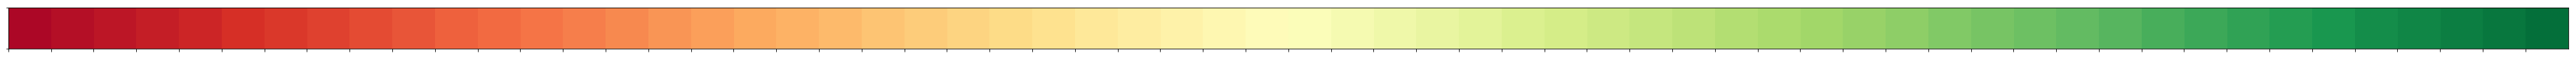

In [101]:
color_palette = sns.color_palette('RdYlGn', df_spec.package_version.cat.categories.size)
sns.palplot(color_palette)

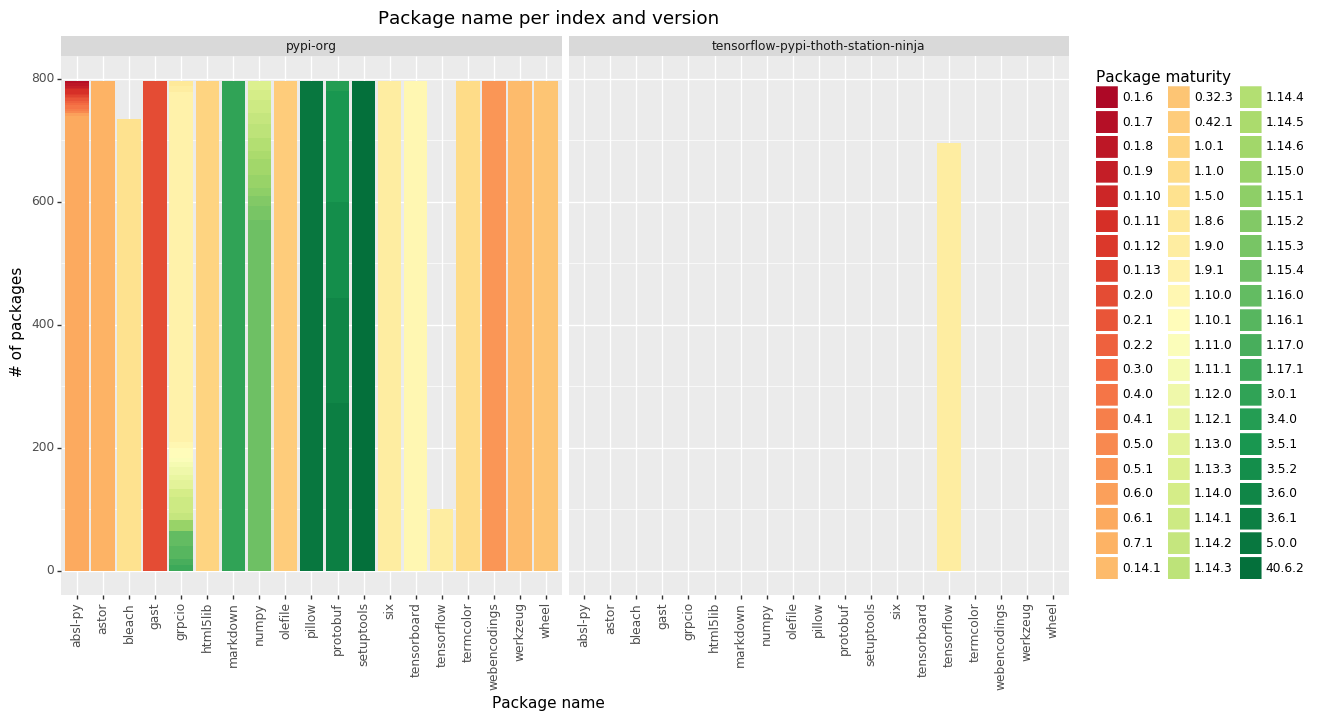

<ggplot: (8791265685936)>

In [102]:
options.figure_size = (13, 7)

(ggplot(df_spec, aes(x='factor(package_name)')) +
     geom_bar(aes(fill='package_version')) +
     facet_wrap('package_index') +
     scale_fill_manual(list(map(to_hex, color_palette))) +
     xlab("Package name") +
     ylab("# of packages") +
     labs(title = "Package name per index and version", fill="Package maturity") +
     theme(
         axis_text_x = element_text(angle = 90)
     )
)

In [103]:
# using plotly to produce the above plot as interactive

grp = df_spec.groupby(['package_name', 'package_version']) \
    .size() \
    .reset_index(name='n') \
    .pivot(index='package_name', columns='package_version', values=['n'])

grp.columns = grp.columns.droplevel().astype(str)

In [104]:
grp.iplot(kind='bar', barmode='stack', colors=map(to_hex, color_palette))

---

# Multivariate

## Performance by matrix size

In [105]:
df_norm = normalize_df(df_perf, cols = ['performance'], groups = ['mat_size'])

In [106]:
df_norm = df_norm \
    .pivot(index='inspection_id', columns='mat_size', values='performance')

df_norm.columns = df_norm.columns.astype(str)
df_norm.head()

mat_size                       256       512      1024
inspection_id                                         
inspect-002c9fbb7513b20b  1.000000  0.552670  0.398890
inspect-003e9fc7135f503f  0.655176  0.005831  0.397400
inspect-0044bd85b0d234cb  0.596200  0.006244  0.401316
inspect-005576c22b9ee846  0.654116  0.104672  0.587578
inspect-005674620e23c058  0.577160  0.467482  0.598343

In [107]:
sub_fig = tools.make_subplots(rows = 3, shared_xaxes=True)

for k, col_idx in enumerate(itertools.combinations(df_norm.columns, r=2)):
    
    sub_fig.append_trace(
        go.Scatter(
            mode='markers',
            name="-".join(col_idx),
            x=df_norm[col_idx[0]],
            y=df_norm[col_idx[1]]
        ),
        k + 1, 1
    )
    
fig = go.FigureWidget(sub_fig, layout=sub_fig.layout)
fig['layout'].update(height=720, width=800, title='Correlation analysis')

iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



In [108]:
import colorlover as cl

fig = ff.create_annotated_heatmap(
    x=[f"dim: {m}" for m in df_norm.columns],
    y=[f"dim: {m}" for m in df_norm.columns],
    z=np.round(df_norm.corr().values, 3),
    opacity=0.8,
    showscale=True,
    colorscale=list(zip([1.0], cl.scales['10']['div']['RdGy'])),
)

fig['layout'].update(title='Performance correlation',
                     xaxis=dict(ticks=''),
                     yaxis=dict(ticks='')
                    )

iplot(fig)

---

## Peformance by specification

In [109]:
df_norm = normalize_df(df_perf, cols = ['performance'], groups = ['mat_size'])

In [110]:
df_norm = df_norm.merge(df_spec)
df_norm.head(3)

elapsed_ms             inspection_id  mat_size  performance        rate  \
0    0.292063  inspect-002c9fbb7513b20b       256          1.0  114.663355   
1    0.292063  inspect-002c9fbb7513b20b       256          1.0  114.663355   
2    0.292063  inspect-002c9fbb7513b20b       256          1.0  114.663355   

  stack                                       stack_digest build__cpu  \
0     A  edbd2fd6350b3861afef5b907cd964b50922c0227f3ec0...       500m   
1     A  edbd2fd6350b3861afef5b907cd964b50922c0227f3ec0...       500m   
2     A  edbd2fd6350b3861afef5b907cd964b50922c0227f3ec0...       500m   

                                 requirements_digest run__cpu run__memory  \
0  4964e06cdd175f4f02673907e5c497b72b54985a4bdaf6...     500m         8Gi   
1  4964e06cdd175f4f02673907e5c497b72b54985a4bdaf6...     500m         8Gi   
2  4964e06cdd175f4f02673907e5c497b72b54985a4bdaf6...     500m         8Gi   

  package_index package_name package_version  
0      pypi-org      absl-py           0.6.1  
1      pypi-org        astor           0.7.1  
2      pypi-org       bleach           1.5.0

In [111]:
df_norm \
    .groupby(['package_name', 'package_version'], sort=False) \
    .package_version \
    .nunique() \
    .groupby('package_name') \
    .sum() \
    .iplot(kind='bar',
           title="Number of unique versions per package",
           yTitle="# versions",
           xTitle="package"
          )

In [112]:
df_norm = df_norm \
    .sort_values(['package_name', 'package_version']) \
    .reset_index(drop=True)

> NOTE: This plot takes a while, but it is worth it

In [113]:
mat_sizes = ('256', '512', '1024')

layout=dict(
    height=960,
    xaxis=dict(
       title="Inspection ID",
       showticklabels=False,
    ),
    yaxis=dict(
       title="Performance",
    ),
    yaxis2=dict(
       title="Performance",
    ),
    yaxis3=dict(
       title="Performance",
    )
)

# precompute figures for quicker updates
fig_data = {}

package_names = df_norm.package_name.unique()
for package in package_names:

    fig = tools.make_subplots(rows=3,
                              shared_xaxes=True,
                              subplot_titles=[f'dim: {dim}' for dim in mat_sizes],
                              print_grid=False)
    
    for idx, mat_size in enumerate(mat_sizes):
        sub_fig = df_norm \
            .query(f"(package_name == '{package}') & (mat_size == {mat_size})") \
            .filter(['inspection_id', 'package_version', 'performance']) \
            .reset_index() \
            .pivot_table(index='index', columns='package_version', values='performance') \
            .iplot(kind='scatter', asFigure=True)

        for trace in sub_fig['data']:
            trace['legendgroup'] = package
            if idx:
                trace['showlegend'] = False  # only show legend once and link it by legendgroup
                
            fig.append_trace(trace, idx + 1, 1)
    
    fig_data[package] = fig.data

layout.update(fig.layout.to_plotly_json())

In [114]:
init_package = 'numpy'

dropdown = widgets.Dropdown(
    options=package_names,
    value=init_package,
    description='Package: ',
)

fig = go.FigureWidget(fig_data[init_package], layout=layout)
fig['layout'].update(layout, title=f"Performance measure by package {init_package}")

def update_on_change(change):
    from IPython.core.display import clear_output
    
    fig = go.FigureWidget(fig_data[change['new']], layout=layout)
    fig['layout'].update(layout)
    fig['layout'].update(title=f"Performance measure by package {change['new']}")
                         
    clear_output()
                         
    display(dropdown)
    display(fig)
    
dropdown.observe(update_on_change, names='value')
                         
display(dropdown)
display(fig)

Dropdown(description='Package: ', index=7, options=('absl-py', 'astor', 'bleach', 'gast', 'grpcio', 'html5lib'…

FigureWidget({
    'data': [{'legendgroup': 'numpy',
              'line': {'color': 'rgba(255, 153, 51, 1.0)'…

> Observation: The noise is present even within a single package version

## Conclusions

Performance measurements exhibit high variance and seem to contain significant noise. Among the reasons why the data is so noisy might be:

- non-normalized performance measurements (i.e, too few samples taken)
- cluster instability
- I/O or network instability

It is yet unclear whether performance can be modeled and we are yet not able to proove that stack configuration, w.r.t both packages and their versions, affects performance (it is certainly believed so, however).

Few ideas for the future work:

- try to normalize the performance measurements by taking more samples per each measure
- take a better look at the concept of `package maturity`
